# Workflow & Hyperparameter Optimization

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

🏠 Import the house price data set. We will keep only numerical features for the sake of simplicity

🎯 Your goal will be to fit the best KNN Regressor. In particular, how many "neighbors" (<font color=blue>K</font> in <font color=blue>K</font>NN) should you consider to get the best predictions for your house prices ?

In [ ]:
# Load raw data
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv')

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [ ]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Train/Test split

❓ **Question (Holdout)**❓

👇 Split the dataset to create your `X_train` `X_test` and `y_train` `y_test`. Use:
- `test_size=0.3`
- `random_state=0` to compare your results with your buddy

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

## 2. Scaling

⚖️ Scaling is always crucially important for the KNN algorithm..

❓ **Question (Scaling)** ❓ 

* Scale your train set and test set.
* Here, let's simply apply the `StandardScaler` and not waste time choosing one scaler per feature. Indeed, the goals of this exercise are to:
    * review KNN
    * understand GridSearchCV
    * understand RandomizedSearchCV

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),
                              columns = X_train.columns)

## 3. Baseline KNN model

❓ **Question (A baseline for our KNN)** ❓

Cross-validate (*cv = 5*) a simple KNN regressor taking into account only _the closest neighbor_, and compute the average score over the 5 folds.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

knn = KNeighborsRegressor(n_neighbors=1)
cross_validate(knn, X_train_scaled, y_train, cv=5)["test_score"].mean()

0.569025195507008

## 4. GridSearch

### 4.1. A first GridSearch

❓ **Question (GridSearch v1)**❓

Let's use SKLearn `GridSearchCV` to find the best KNN hyperparameter `n_neighbors`.
- Start a coarse-grain approach, with `n_neighbors` = [1,5,10,20,50]
- 5-fold cross-validate each parameter
- Make sure to maximize your performance time using `n_jobs`

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Instanciate model
# $DELETE_BEGIN
model = KNeighborsRegressor()
# $DELETE_END

# Hyperparameter Grid
# $DELETE_BEGIN
k_grid = {'n_neighbors' : [1,5,10,20,50]}
# $DELETE_END

# Instanciate Grid Search
# $DELETE_BEGIN
grid = GridSearchCV(model, k_grid, n_jobs=-1,  cv = 5)
# $DELETE_END

# Fit data to Grid Search
# $DELETE_BEGIN
grid.fit(X_train_scaled, y_train)
# $DELETE_END

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50]})

❓ **Question (best parameters)** ❓

According to the GridSearch, what is the optimal K value?

In [ ]:
grid.best_params_

{'n_neighbors': 20}

❓ **Question (scoring)** ❓ What is the best score the optimal K value produced?

In [ ]:
grid.best_score_

0.7594265833471792

### 4.2. A second GridSearch

❓ **Question (GridSearch V2)** ❓


Now, we have an idea about where the best $K$ lies, but some of the values we didn't try could result in a  better performance.

* Re-run a GridSearch trying some values for $K$ around to your previous best value
* What are the `best_score` and `best_k` for this refined GridSearch?

In [ ]:
# Instanciate model
# $DELETE_BEGIN
model = KNeighborsRegressor()
# $DELETE_END

# Hyperparameter Grid
# $DELETE_BEGIN
k_grid = {'n_neighbors' : np.arange(11,30,1)}
# $DELETE_END

# Instanciate Grid Search
# $DELETE_BEGIN
grid = GridSearchCV(model, k_grid, n_jobs=-1,  cv = 5)
# $DELETE_END

# Fit data to Grid Search
# $DELETE_BEGIN
grid.fit(X_train_scaled, y_train)

print(grid.best_params_["n_neighbors"])
print(grid.best_score_)
# $DELETE_END

14
0.7655062000041237


In [ ]:
best_k = grid.best_params_["n_neighbors"]
best_score = grid.best_score_

***🧪 Test your code***

In [ ]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/davywai/.pyenv/versions/lewagon_data_staff/bin/python3
cachedir: .pytest_cache
rootdir: /Users/davywai/code/lewagon/data-solutions/05-ML/05-Model-Tuning/01-Workflow
plugins: anyio-3.4.0
collecting ... collected 2 items

tests/test_knn.py::TestKnn::test_best_k PASSED                           [ 50%]
tests/test_knn.py::TestKnn::test_best_score PASSED                       [100%]

============================== 2 passed in 0.12s ===============================


💯 You can commit your code:

git add tests/knn.pickle

git commit -m 'Completed knn step'

git push origin master


### 4.3. Visual check (manual GridSearch)

☝️ This problem is actually simple enough to perform a GridSearch manually.

❓ **Question(Manual GridSearch)** ❓

- Loop manually over all values of $K$ from $1$ to $50$ and store the average of the cross-validated scores of each model in a list.
- Plot the scores as a function of $K$ to visually find the best $K$ using the `Elbow Method`

In [ ]:
scores=[]
for k in range(1,50):
    knn = KNeighborsRegressor(n_neighbors=k)
    scores.append(cross_validate(knn, X_train_scaled, y_train, cv=5)["test_score"].mean())

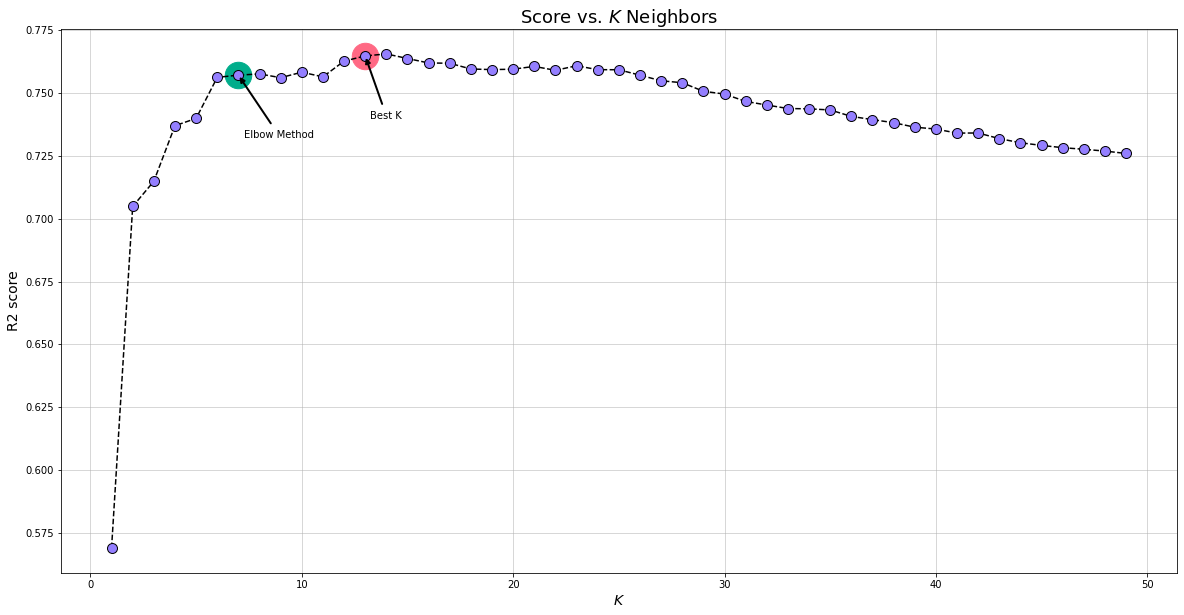

In [ ]:
import matplotlib.pyplot as plt

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(20,10))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(range(1,50),scores,color='black', linestyle='dashed', marker='o',markerfacecolor='#947FFF', markersize=10)
    # more
    ax.set_title('Score vs. $K$ Neighbors', fontsize = 18)
    ax.set_xlabel('$K$', fontsize = 14)
    ax.set_ylabel('R2 score', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    # best K
    # focusing
    ax.scatter(7,scores[7-1],c='#00ad8b',s=700)
    ax.scatter(13,scores[13-1],c='#ff6984',s=700)
    
    # annotate
    ax.annotate("Elbow Method", 
                xy=(7,scores[7-1]),
                xytext=(7+0.25,scores[7-1]-0.025), 
                arrowprops=dict(arrowstyle='-|>',
                                fc="k",
                                ec="k",
                                lw=2),
                bbox=dict(pad=5, facecolor="none", edgecolor="none")
               )
    
    ax.annotate("Best K", 
            xy=(13,scores[13-1]),
            xytext=(13+0.25,scores[13-1]-0.025), 
            arrowprops=dict(arrowstyle='-|>',
                            fc="k",
                            ec="k",
                            lw=2),
            bbox=dict(pad=5, facecolor="none", edgecolor="none")
           )

    # spines
    
    
    plt.show()

❓Can you guess what makes GridSearchCV a better option than such manual loop ?


<details>
    <summary>Answer</summary>

- Sklearn's `n_jobs=-1` allows you to paralellize search of each CPU
- What if you had multiple hyper-parameters to co-optimize ?
</details>

## 5. GridSearch with multiple parameters

👩🏻‍🏫 KNNRegressor suppports various _distance metrics_ via the hyper-parameter `p` 

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Question (tuning multiple parameters)** ❓


* Use GridSearchCV to search for the best $K$ and $p$ simultaneously.
    * Try all combinations for $K = [1, 5, 10, 20, 50]$ and $p = [1, 2, 3]$. 

In [ ]:
model = KNeighborsRegressor()
k_grid = {'n_neighbors' : [1, 5, 10, 20, 50],
          'p': [1,2,3]}
grid = GridSearchCV(model, k_grid,
                     cv = 5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50], 'p': [1, 2, 3]})

❓ **Question (number of submodels)**❓

How many submodels did you train overall?

<details>
    <summary>Hint</summary>

Much more than 15. Think twice :)
    <details>
    <summary>Answer</summary>

75 models due to CV=5
</details>

In [ ]:
# 75 models due to CV=5

❓ **Question (best parameters and best score after tuning the model with multiple parameters)**❓

What are the *best parameters* and the *best score*?

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 10, 'p': 1}
0.7978142226309175


## 6. Random Search

Now let's see whether a RandomizedSearch can find a better combination with the same number of models being fitted.

❓ **Question (RandomizedSearchCV)** ❓

Use `RandomizedSearchCV` to
- Randomly sample $K$ from a uniform `randint(1,50)` distribition
- Sample $p$ from a list $[1,2,3]$
- Use the correct numbers of `n_iter` and `cv` to fit the exact same numbers of models as in your previous GridSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

model = KNeighborsRegressor()

search_space = {'n_neighbors': randint(1, 50), 'p': [1, 2, 3]}

search = RandomizedSearchCV(model, param_distributions=search_space,
                            n_jobs=-1,  cv=5, n_iter=15)

search.fit(X_train_scaled, y_train)

print(search.best_score_)
print(search.best_params_)

0.7882195188411149
{'n_neighbors': 12, 'p': 1}


## 7. Generalization

❓ **Question (finetuning your model one more time)**❓

- Refine your RandomsearchCV if you want
- Choose your best model and instantiate it
- Re-fit it on the __entire__ train set

In [ ]:
best_model = search.best_estimator_
best_model.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=12, p=1)

❓ **Question (Evaluation of the "best" model)** ❓

* Time has come to discover our model's performance with "best params" on the **unseen** test set `X_test`.
    * Compute the r2 score for the test set and save it as `r2_test`.

In [ ]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test, best_model.predict(scaler.transform(X_test)))
r2_test

/Users/davywai/.pyenv/versions/3.8.12/envs/lewagon_data_staff/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


0.7688052067958326

❓ **Question (Taking a step back)** ❓

Would you consider the optimized model to generalize well?

<details><summary>Answer</summary>

Test score may decrease a bit with train set. Probably not more than 5%. This can be due to
- A non-representative train/test split
- A cross-val number too small leading to overfitting the model-tuning phase. The more you cross-validated, the more robust your findings will generalize - but you can't increase cv too much if your dataset is too small as you won't keep enough observations in each fold to be representative.
- Our dataset is very small and our hyperparameter optimization is thus extremely dependent (and overfitting) on our train/test split. Always make sure your dataset is much bigger than the total number of hyperparameter combinations you are trying out!
    
</details>

***🧪 Test your code***

In [ ]:
from nbresult import ChallengeResult
result = ChallengeResult('r2', 
                         r2_test=r2_test)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/davywai/.pyenv/versions/lewagon_data_staff/bin/python3
cachedir: .pytest_cache
rootdir: /Users/davywai/code/lewagon/data-solutions/05-ML/05-Model-Tuning/01-Workflow
plugins: anyio-3.4.0
collecting ... collected 1 item

tests/test_r2.py::TestR2::test_r2 PASSED                                 [100%]

============================== 1 passed in 0.10s ===============================


💯 You can commit your code:

git add tests/r2.pickle

git commit -m 'Completed r2 step'

git push origin master


🏁 Congratulations! Now, you know how to finetune a model using either a GridSearchCV or a RandomizedSearchCV 

💾 Don't forget to `git add/commit/push` your notebook...

🚀 ... and move on to the next challenge!